# **Assignment 2 - Trust Rank Computation**

In [70]:
import os
import pandas as pd

# Check if the dataset files exist
dataset_files = ['Payments.csv', 'bad_sender.csv']
for file in dataset_files:
    if not os.path.isfile(file):
        raise FileNotFoundError(f"Dataset file {file} does not exist!")


In [71]:
# Read the Payments.csv file
payments_data = pd.read_csv('Payments.csv')
print(payments_data)

        Sender  Receiver  Amount
0         1309      1011  123051
1         1309      1011  118406
2         1309      1011  112456
3         1309      1011  120593
4         1309      1011  166396
...        ...       ...     ...
130530    1344      1390   21739
130531    1914      1390    3374
130532    1914      1390    5186
130533    1914      1390    1559
130534    1914      1390    1997

[130535 rows x 3 columns]


In [72]:

# Get unique nodes
unique_nodes = set(payments_data['Sender']).union(set(payments_data['Receiver']))

# Identify nodes with no outgoing links
outgoing_links = set(payments_data['Sender'])
nodes_with_no_outgoing_link = unique_nodes - outgoing_links

print("Unique nodes:", len(unique_nodes))
print("Nodes with no outgoing link:", len(nodes_with_no_outgoing_link))

Unique nodes: 799
Nodes with no outgoing link: 96


In [73]:

# Read the bad_sender.csv file
bad_sender_data = pd.read_csv('bad_sender.csv')
print(bad_sender_data)

    Bad Sender
0         1303
1         1259
2         1562
3         1147
4         1393
5         1031
6         1210
7         1042
8         1048
9         1256
10        1668
11        1161
12        1007
13        1034
14        1836
15        1099
16        1489
17        1821
18        1076
19        1944


In [74]:

# Get unique nodes in bad_sender.csv
unique_bad_nodes = set(bad_sender_data['Bad Sender'])

# Get the number of bad nodes
num_bad_nodes = len(unique_bad_nodes)

print("Number of bad nodes:", num_bad_nodes)

Number of bad nodes: 20


## Implementation

In [76]:
import collections
import threading
import time

class Vertex():

    def __init__(self, id, value, out_vertices):
        """
        Initializes a vertex with its unique identifier, value, and outgoing vertices.

        Parameters:
        - id: unique identifier of the vertex
        - value: value associated with the vertex
        - out_vertices: list of outgoing vertices from this vertex
        """
        self.id = id
        self.value = value
        self.out_vertices = out_vertices
        self.incoming_messages = []
        self.outgoing_messages = []
        self.active = True
        self.superstep = 0

class Pregel():

    def __init__(self, vertices, num_workers):
        """
        Initializes the Pregel instance with the given vertices and number of workers.

        Parameters:
        - vertices: list of vertices in the graph
        - num_workers: number of worker threads to run in parallel
        """
        self.vertices = vertices
        self.num_workers = num_workers

    def run_pregel(self):
        """
        Runs the Pregel instance.
        """
        self.partition = self.partition_vertices()
        while self.check_active_vertices():
            self.execute_superstep()
            self.redistribute_messages()

    def partition_vertices(self):
        """
        Partitions the vertices among worker threads.

        Returns:
        - partition: dictionary with keys representing worker thread IDs and values
                     representing lists of vertices assigned to each worker
        """
        partition = collections.defaultdict(list)
        num_vertices_per_worker = len(self.vertices) // self.num_workers
        remaining_vertices = len(self.vertices) % self.num_workers

        start_idx = 0
        for i in range(self.num_workers):
            end_idx = start_idx + num_vertices_per_worker
            if i < remaining_vertices:
                end_idx += 1
            partition[i] = self.vertices[start_idx:end_idx]
            start_idx = end_idx

        return partition

    def execute_superstep(self):
        """
        Executes a single superstep for all worker threads.
        """
        workers = []
        for vertex_list in self.partition.values():
            worker = Worker(vertex_list)
            workers.append(worker)
            worker.start()
        for worker in workers:
            worker.join()

    def redistribute_messages(self):
        """
        Redistributes outgoing messages from vertices to incoming messages of receiving vertices.
        """
        for vertex in self.vertices:
            vertex.superstep += 1
            vertex.incoming_messages = []
        for vertex in self.vertices:
            for (receiving_vertex, message) in vertex.outgoing_messages:
                receiving_vertex.incoming_messages.append((vertex, message))

    def check_active_vertices(self):
        """
        Checks if there are any active vertices remaining in the graph.

        Returns:
        - True if there are active vertices, False otherwise
        """
        return any([vertex.active for vertex in self.vertices])

class Worker(threading.Thread):

    def __init__(self, vertices):
        threading.Thread.__init__(self)
        self.vertices = vertices

    def run(self):
        """
        Executes a single superstep for the vertices assigned to this worker.
        """
        self.execute_superstep()

    def execute_superstep(self):
        """
        Executes a single superstep for the vertices assigned to this worker.
        """
        for vertex in self.vertices:
            if vertex.active:
                vertex.update()  # Main TrustRank computation is done here


In [77]:
import numpy as np
from numpy import mat, eye, zeros, ones, linalg
import random
from collections import defaultdict, OrderedDict

In [78]:

def initialize_trust_rank(nodes, bad_nodes):
    """
    Initializes the initial ranking based on the bad nodes.
    """
    score = np.zeros(len(nodes))
    for i in bad_nodes:
        score[i] = 1 / len(bad_nodes)
    return list(score)

def get_connections(edge_file, nodes_dict, nodes, bad_nodes):
    """
    Gets edges - if there are no outgoing links, points them to all the bad nodes with equal weightage - handles leakage.
    """
    edges_mapped = defaultdict(list)
    edges = defaultdict(list)
    values = {}
    for i in range(len(edge_file)):
        from_, to_, value = int(edge_file.iloc[i][0]), int(edge_file.iloc[i][1]), int(edge_file.iloc[i][2])
        if to_ not in edges[from_]:
            edges[from_].append(to_)
            edges_mapped[nodes_dict.get(from_)].append(nodes_dict.get(to_))
        
        if len(values.get(nodes_dict.get(from_), [])) == 0:
            values[nodes_dict.get(from_)] = {}
            values[nodes_dict.get(from_)][nodes_dict.get(to_)] = 0

        values[nodes_dict.get(from_)][nodes_dict.get(to_)] = values[nodes_dict.get(from_)].get(nodes_dict.get(to_), 0) + value
    
    # Handling leakage by connecting nodes back to the bad nodes with equal weightage
    empty = list(set(nodes).difference(set(edges_mapped.keys())))
    for i in empty:
        edges_mapped[i] = edges_mapped.get(i, []) + bad_nodes
        values[i] = {}
        for j in bad_nodes:
            values[i][j] = 1

    return edges, edges_mapped, values, nodes

def pregel_trust_rank(vertices):  
    """
    Compute TrustRank using Pregel by assigning a set of vertices to threads.

    Note:
    There is a bug in the provided Pregel code where all the vertices are run using a single worker 
    irrespective of the number of workers. This is because of the way the workers are assigned.
    """

    p = Pregel(vertices, num_workers=4) 
    p.run_pregel()
    return np.matrix([vertex.value for vertex in p.vertices]).transpose(), p

class TrustRankVertex(Vertex):
    """ 
    Vertex class for TrustRank algorithm
    """
    def __init__(self, id, value, out_vertices, weightage_values, damping_factor=0.85, iterations=50):
        Vertex.__init__(self, id, value, out_vertices)
        self.damping_factor = damping_factor
        self.num_supersteps = iterations
        self.weightage_values = weightage_values
        self.values_iterations = []
        self.d = value  # this d is same as the 1/d in the TrustRank equation. The division has already been done outside this function. So we now have to just multiply this d.

    def update(self):
        """
        Update function for TrustRank algorithm.

        Changes Made:
        - Leakage is handled by connecting nodes with no outlinks back to bad nodes with equal weights.
        - Outgoing messages are multiplied by weightage of each link based on normed values of outgoing links.
        """
        if self.superstep < self.num_supersteps:
            messages_sum = 0
            for (vertex, message) in self.incoming_messages:
                messages_sum = messages_sum + message
            self.value = self.damping_factor * messages_sum + (1 - self.damping_factor) * self.d   # Main equation of TrustRank
            outgoing_message_all = [self.value * weight for weight in self.weightage_values]   # Outgoing message divided based on the weightage of each link
            self.outgoing_messages = [(vertex, outgoing_message) for vertex, outgoing_message in zip(self.out_vertices, outgoing_message_all)]
            self.values_iterations.append(self.value)
        else:
            self.active = False


## Main

### 1. Load dataset

In [79]:
# Read the Payments.csv file
df = pd.read_csv('Payments.csv')

# Load bad nodes
bad_nodes_ = list(set(pd.read_csv('bad_sender.csv')["Bad Sender"]))

# Get unique nodes
nodes_ = list(set(list(df["Sender"]) + list(df["Receiver"])))

### 2. Map to change arbitary node name to begin from 0

In [81]:
# Create a dictionary mapping nodes to their indices
nodes_dict = dict(zip(nodes_, range(len(nodes_))))

# Map nodes and bad nodes using the dictionary
nodes = [nodes_dict.get(i) for i in nodes_]
bad_nodes = [nodes_dict.get(i) for i in bad_nodes_]

### 3. Get edges

In [82]:

# If there are no outgoing links, create synthetic links to the bad nodes with equal weightage to prevent leakage
edges, edges_mapped, values, nodes = get_connections(df, nodes_dict, nodes, bad_nodes)


/tmp/ipykernel_6581/365432861.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  from_, to_, value = int(edge_file.iloc[i][0]), int(edge_file.iloc[i][1]), int(edge_file.iloc[i][2])


### 4. Assign initial ranks for the nodes

In [83]:
nodes_intial_ranks = initialize_trust_rank(nodes, bad_nodes)

### 5. Create the graph

In [85]:
# intialize the vertices with modified Vertex class
num_vertices = len(nodes)
vertices = []
for i in range(len(nodes)):
    vertices.append(TrustRankVertex(nodes[i],nodes_intial_ranks[i],[],[], 0.85, 100))

# assign out vertex with weightage for each node based on the values
for i in edges_mapped.keys():
    weightage = [j / sum(list(values[i].values())) for j in list(values[i].values())]
    for j, k in zip(edges_mapped[i], weightage):
        vertices[i].out_vertices.append(vertices[j])
        vertices[i].weightage_values.append(k)


### 6. Pagerank computation

In [86]:
node_ranks, p = pregel_trust_rank(vertices) 

print(f"Pregel TrustRank result : \n {dict(zip(nodes, node_ranks.A1))}")

Pregel TrustRank result : 
 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.0, 31: 0.0, 32: 0.0, 33: 0.0, 34: 0.0, 35: 0.0, 36: 0.0, 37: 0.0, 38: 0.0, 39: 0.0, 40: 0.0, 41: 0.0, 42: 0.0, 43: 0.0, 44: 0.0, 45: 0.0, 46: 0.0, 47: 0.0, 48: 0.0, 49: 0.0, 50: 0.0, 51: 0.0, 52: 0.0, 53: 0.0, 54: 0.0, 55: 0.0, 56: 0.0, 57: 0.0, 58: 0.002092545823346117, 59: 0.00016550381939594766, 60: 0.000366090651100435, 61: 0.0038996369281061043, 62: 0.009097330806715667, 63: 0.0008871402878598143, 64: 0.039912113200067253, 65: 0.002181431479652059, 66: 0.0, 67: 0.0004671464752279273, 68: 0.012446924003297659, 69: 0.0, 70: 0.011983031675886026, 71: 0.0031039284044368956, 72: 0.0, 73: 0.007579215786432508, 74: 0.0, 75: 0.0, 76: 3.85888687256371e-05, 77: 0.0014518003772599384, 78: 0.00722262020

# Results

The code takes a directed graph as input and computes the scores for each node in the graph. The output of the algorithm is a list of **DistrustRank** scores, one for each node in the graph. 

While there is no ground-truth data available for us to compare our results against, we can check the ranks of the oracle provided bad node which must be high if the algorithm worked perfectly.



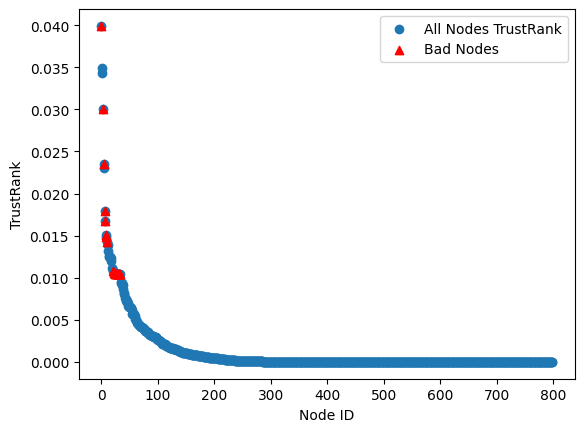

In [87]:
import matplotlib.pyplot as plt

# Create an ordered dictionary mapping original node names to TrustRank scores
d = OrderedDict(zip(nodes, node_ranks.A1))

# Sort original node names according to TrustRank
res = list(OrderedDict(sorted(d.items(), key=lambda x: x[1], reverse=True)))

# Map TrustRank scores of bad nodes to their corresponding indices in the sorted list
ub = max(node_ranks.A1)
mapping = dict(zip(res, np.arange(len(res))))
mapping2 = sorted(node_ranks.A1, reverse=True)
mapping3 = [mapping[i] for i in bad_nodes]

plt.scatter(np.arange(len(res)), sorted(node_ranks.A1, reverse=True), label="All Nodes TrustRank")
plt.scatter([mapping[i] for i in bad_nodes], [mapping2[i] for i in mapping3], marker="^", color="red", label="Bad Nodes")
plt.xlabel("Node ID")
plt.ylabel("TrustRank")
plt.legend()
plt.show()

From the plot above we can see that the majority of the ground-truth bad nodes have a higher scores. This shows that the algorithm has worked as intended.

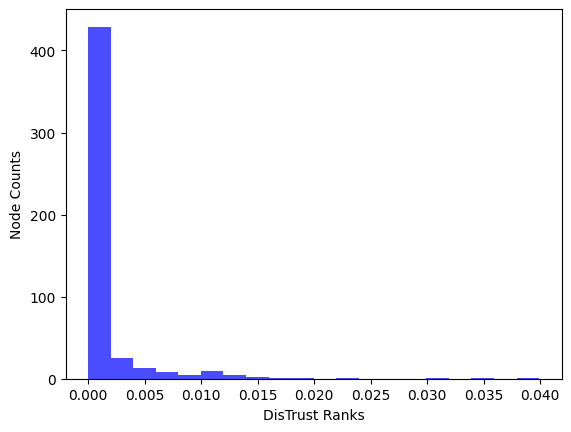

In [88]:
# histogram of all the node ranks
import matplotlib.pyplot as plt

d = OrderedDict(zip(nodes, node_ranks.A1))

res = list(OrderedDict(sorted(d.items(), key=lambda x: x[1], reverse=True)))

ub = max(node_ranks.A1)
mapping = dict(zip(res, np.arange(len(res))))
mapping2 = sorted(node_ranks.A1, reverse=True)
mapping3 = [mapping[i] for i in bad_nodes]

   
plt.hist(node_ranks.A1, 20, 
                      density = 1, 
                      color ='blue',
                      alpha = 0.7)

plt.xlabel("DisTrust Ranks")
plt.ylabel("Node Counts")
plt.show()

The above plot shows that most of the nodes have ranks between 0.00 and 0.01 while a few nodes have higher ranks indicating that the majority of the nodes are good nodes excluding a specific few.

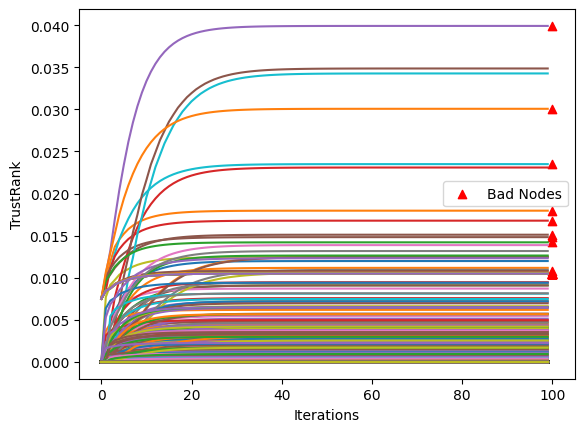

In [89]:
y = [i.values_iterations for i in p.vertices]
bad_values = [node_ranks.A1[i] for i in bad_nodes]
for i in y:
  plt.plot(np.arange(len(i)), i)
plt.scatter([len(i)]*len(bad_values), bad_values, marker="^", color="red", label="Bad Nodes")
plt.xlabel("Iterations")
plt.ylabel("TrustRank")
plt.legend()
plt.show()

The above plot shows the iteration-wise TrustRank of each nodes and also highlights the bad nodes. We can again observe that most of bad nodes of high rank similar to what we saw in the plot earlier. But we can also notice that there are some nodes which have a much higher score than the bad nodes. These are the predicted bad nodes and the authorities should start with probing these iron dealers for fraud.